In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils.dataset_processing_utils as dputil


SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
legalization_df = dputil.load_dataset('legalization.csv', encoding='utf-16')

---

### Country categorization:
In order to examine how legislation on the subject of cannabis affects drug follow in the respected countries, we first devise the following 4 groups of countries, and their current legal state on cannabis (see the table below):

| Category | Category abbreviation | Recreational legal status | Medical legal status |
| --- |-----------------------|---------------------------|----------------------|
| Prohibition | ILL                   | Illegal                   | Illegal              |
| Decriminialized | DEC |  Decriminalized           | Illegal              |
| Medically legal | MED | Decriminalized/Illegal | Legal/CBD only       |
| Full legality | LGL | Legal | Legal                |

**Note** - For decriminalization policies - we do have to differentiate between the volume of drugs one citizen can have have on his possession, as it will be accounted for when pairing it with the drug seizures data. Mainly, we speculate that some of these incidents may not be recorded due to this.

Additionally, we will also remove the 'Notes' as it is no longer necessary after the manual processing in the main notebook
We also need to dismiss of North Korea, as they're the only country with the value of 'Unknown' (Probably since they did not disclose information to the UN)

Finally - we arrange, rename according to the schema and the columns and remove unnecessary columns - _Notes_, _Recreational_ and _Medical_

In [3]:
def legal_status_categorization(row: pd.Series) -> str:
    """A simple switch case to categorize a pandas dataframe row to one of 4 categories:
    1. LGL - 'Recreational' column has the value 'Legal'.
    2. MED - 'Recreational' column is either 'Illegal' or 'Decriminalized', and 'Medical' column has one of the following values: 'Legal' or 'CBD only'.
    3. DEC - 'Recreational' column has the value 'Decriminalized'. 'Medical' has the value 'Illegal'.
    4. ILL - 'Recreational' and 'Medical' columns both have the value 'Illegal'.
    """
    if row['Recreational'] == 'Legal':
        return 'LGL'
    elif row['Medical'] in ['CBD only', 'Legal']:
        return 'MED'
    elif row['Recreational'] == 'Decriminalized' and row['Medical'] == 'Illegal':
        return 'DEC'
    else:
        return 'ILL'

legalization_df['legal_category'] = legalization_df.apply(lambda row: legal_status_categorization(row), axis=1)
# Drop rows with 'Unknown' values
legalization_df = legalization_df.query('Recreational != "Unknown" | Medical != "Unknown"')

# reorder the columns for better visualization:
col_name_mapping = {
    "Country/Territory": "country",
    "Recreational_year": "recreational_year",
    "Mediacal_year": "medical_year",
    "Decriminalized_max_possession": "decriminalized_max_possession"
}
column_order = legalization_df.columns.tolist()
column_order.insert(1, 'legal_category')
column_order.pop(len(column_order) - 1)
[column_order.remove(x) for x in ["Recreational", "Medical", "Notes"]]
legalization_df_sorted = legalization_df[column_order]
legalization_df_sorted.rename(columns=col_name_mapping, inplace=True)
legalization_df_sorted.sample(10, random_state=SEED-2).sort_values("legal_category")

C:\Users\User\AppData\Local\Temp\ipykernel_10444\2963063287.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legalization_df_sorted.rename(columns=col_name_mapping, inplace=True)


,country,legal_category,recreational_year,medical_year,decriminalized_max_possession
5,Antigua and Barbuda,DEC,NaN,NaN,NaN
117,Moldova,DEC,NaN,NaN,NaN
54,Estonia,DEC,NaN,NaN,7.5
97,Latvia,ILL,NaN,NaN,1.0
184,Turkmenistan,ILL,NaN,NaN,NaN
161,Singapore,ILL,NaN,NaN,NaN
90,Kiribati,ILL,NaN,NaN,NaN
192,Uzbekistan,ILL,NaN,NaN,NaN
35,Colombia,MED,NaN,2009.0,22.0
135,Pakistan,MED,NaN,2020.0,NaN


#### 4.2.2 - Changes in legalization legislation over time
The following plots display the amount of countries that adopted the policy type.
Figure 2.a displays the adoption of cannabis legalization for medical use (even if it is for a specific substance, like CBD),
and figure 2.b shows the same notion but for recreational use of cannabis.
We have highlighted the years 2018–2022, as they are bounded by these years in the *seizures* dataset.

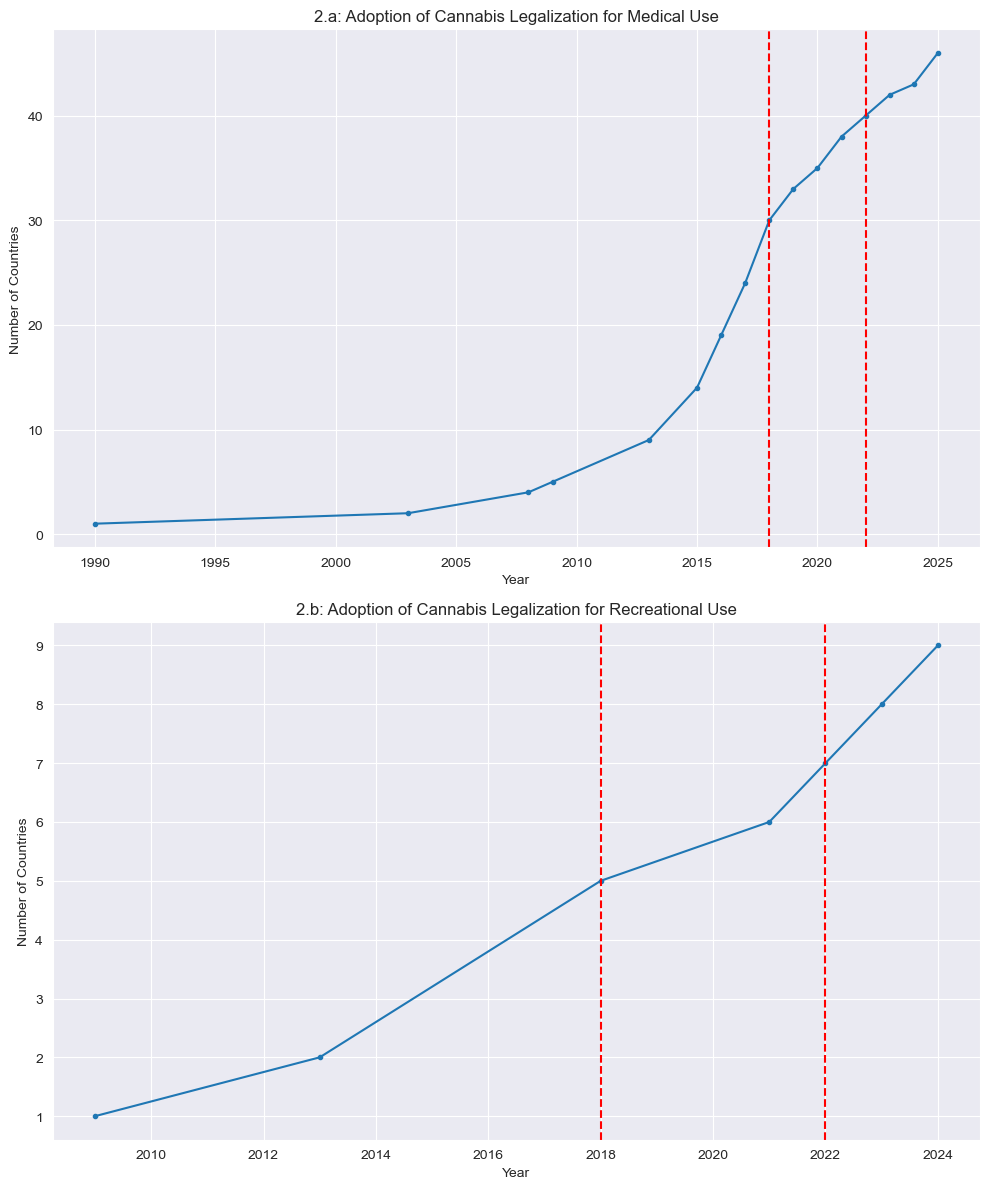

In [15]:
# Filter for medical use legalization and count cumulative sum
med_adoption = legalization_df_sorted[legalization_df_sorted['legal_category'] == 'MED'].groupby('medical_year').size().sort_index().cumsum()

# Filter for recreational use legalization and count cumulative sum
rec_adoption = legalization_df_sorted[legalization_df_sorted['legal_category'] == 'LGL'].groupby('recreational_year').size().sort_index().cumsum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Subplot 2.a: Medical Use Legalization
ax1.plot(med_adoption.index, med_adoption.values, marker='o', linestyle='-', markersize=3)
ax1.axvline(x=2018, color='r', linestyle='--')
ax1.axvline(x=2022, color='r', linestyle='--')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Countries')
ax1.set_title('2.a: Adoption of Cannabis Legalization for Medical Use')
ax1.grid(True)

# Subplot 2.b: Recreational Use Legalization
ax2.plot(rec_adoption.index, rec_adoption.values, marker='o', linestyle='-', markersize=3)
ax2.axvline(x=2018, color='r', linestyle='--')
ax2.axvline(x=2022, color='r', linestyle='--')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Countries')
ax2.set_title('2.b: Adoption of Cannabis Legalization for Recreational Use')
ax2.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Key points

1) From figure 2.a - we can see that in 2022, there we overall 40 countries that have legalized cannabis for medical uses, 10 of them had been added between 2018-2022 - making them prominent candidates test our hypothesis.
2) From figure 2.b, we infer that we don't have many cases of countries that enacted full legalization of cannabis, having only **9** total countries in 2024. Furthermore, between 2018 and 2022, there was only one country - Malta, that adopted these laws. We do however, see that in 2018 - **3** countries have legalized cannabis for all purposes, so if we could expand the seizure data, we could add these countries to our analysis as well.

---

#### 4.2.3 - Analyzing possession limits distribution for countries with decriminalization policies
We speculate that the distribution might help us find a trend in policy adoption.
Alternatively, help us understand the trends in drug trafficking seizures and criminal arrests incidents.

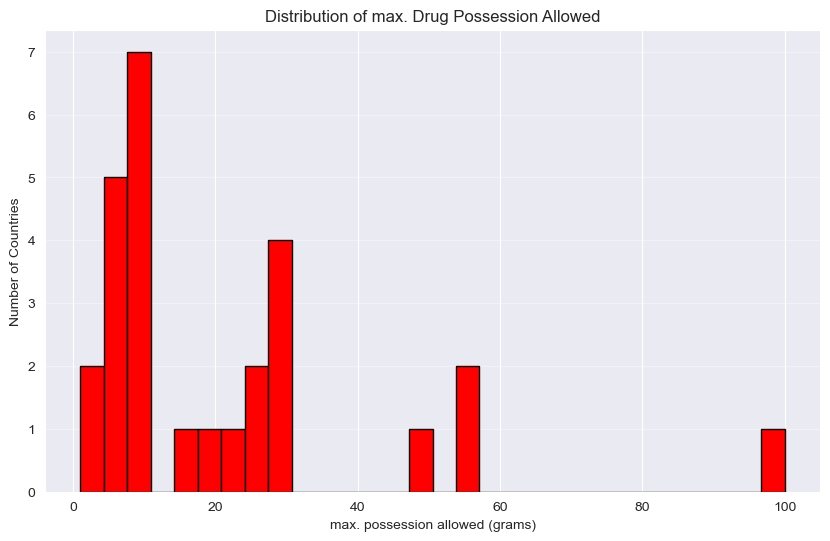

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(legalization_df['Decriminalized_max_possession'].dropna(), bins=30, color='red', edgecolor='black')
plt.xlabel('max. possession allowed (grams)')
plt.ylabel('Number of Countries')
plt.title('Distribution of max. Drug Possession Allowed')
plt.grid(axis='y', alpha=0.35)

#### Key Notes:
As it could be seen above, most countries consider a 30 gram amount of cannabis possession as a non-criminal offense. This could help us explain the sudden shift in seizures found in [figure 1.b](#figure-1b) for cannabis

---

### 4.3 - *wbg_pop_health_gdp* dataset

This dataset contains demographic data that will act as input features for the models and as normalization factors - $VPC_{year}=Z_{year}/p_{year}$ where:
- $VPC_{year}$: value per capita for a country in some year.
- $Z_{year}$: any numerical variable, for example *seizure_volume*.
- $p_{year}$: The country's population given in the given year.

#### 4.3.1 - overview features

Let us look again at the raw data we have exported:
